In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xmfaizan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:07<00:00, 102MB/s] 


In [2]:
import torch
from torch import nn # neural network
from torch.optim import Adam # optimizer

In [3]:
import torchvision.transforms as transforms # used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers

In [4]:
import matplotlib.pyplot as plt
from PIL import Image # Used to read the images from the directory
import pandas as pd
import numpy as np
import os # Used to read the images path from the directory

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [6]:
image_path = []
labels = []
#making a dataframe to have train, test, valid
for i in os.listdir("/content/animal-faces/afhq/"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
data_df.head()

,image_paths,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


In [7]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # testing is by removing the 70% of the train data %

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index)

#Training set 70.0 %, Validation set 15.0 %, Testing set 15.0 %

In [8]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels'])

LabelEncoder()

In [9]:
# give imgs in ds the same properties
transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

In [10]:
#Dataset Obj
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # Initialize dataset with dataframe and optional transformations
        self.dataframe = dataframe
        self.transform = transform
        # Encode labels and move them to the specified device
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        # Return the total number of samples in the dataset
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        # Fetch image path and corresponding label for the given index
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        # Open the image and convert it to RGB format
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided, and move image to the specified device
        if self.transform:
            image = self.transform(image).to(device)

        # Return the transformed image and its corresponding label
        return image, label


In [11]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

In [12]:
#hyperparameters


LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [13]:
#DataLoaders


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
#Model Class

class Net(nn.Module):
    def __init__(self):
      super().__init__()
      #define layers
      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x): #forward pass
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device

In [15]:
#summary
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [16]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR)

In [17]:
# Initialize lists to store training and validation loss/accuracy for each epoch
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Loop through each epoch
for epoch in range(EPOCHS):
    # Initialize accumulators for training and validation loss/accuracy
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    # Training phase
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients before each batch
        outputs = model(inputs)  # Forward pass
        train_loss = criterion(outputs, labels)  # Compute loss(comparing)
        total_loss_train += train_loss.item()  # Accumulate training loss
        train_loss.backward()  # Backpropagation

        # Calculate training accuracy
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()  # Update model weights

    # Validation phase (no gradient calculation)
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)  # Forward pass
            val_loss = criterion(outputs, labels)  # Compute validation loss
            total_loss_val += val_loss.item()  # Accumulate validation loss

            # Calculate validation accuracy
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    # Calculate and store average loss/accuracy for this epoch
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))

    # Print epoch summary
    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
    print("="*25)

Epoch 1/10, Train Loss: 3.0885 Train Accuracy 82.3488
              Validation Loss: 0.3435 Validation Accuracy: 92.3967
Epoch 2/10, Train Loss: 1.2933 Train Accuracy 93.3575
              Validation Loss: 0.2352 Validation Accuracy: 95.3306
Epoch 3/10, Train Loss: 0.8262 Train Accuracy 95.7665
              Validation Loss: 0.2175 Validation Accuracy: 95.3306
Epoch 4/10, Train Loss: 0.5974 Train Accuracy 97.0242
              Validation Loss: 0.1936 Validation Accuracy: 95.7438
Epoch 5/10, Train Loss: 0.4181 Train Accuracy 97.8744
              Validation Loss: 0.1669 Validation Accuracy: 96.5702
Epoch 6/10, Train Loss: 0.3399 Train Accuracy 98.2995
              Validation Loss: 0.1736 Validation Accuracy: 96.8182
Epoch 7/10, Train Loss: 0.2145 Train Accuracy 98.9903
              Validation Loss: 0.1942 Validation Accuracy: 96.405
Epoch 8/10, Train Loss: 0.1743 Train Accuracy 99.1852
              Validation Loss: 0.2248 Validation Accuracy: 95.9917
Epoch 9/10, Train Loss: 0.1415 Tr

In [18]:
# Testing phase (no gradient calculation)
with torch.no_grad():
    total_loss_test = 0  # Initialize test loss accumulator
    total_acc_test = 0   # Initialize test accuracy accumulator

    # Iterate through test data
    for inputs, labels in test_loader:
        predictions = model(inputs)  # Forward pass to get predictions

        # Calculate accuracy by comparing predictions with actual labels
        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc

        # Compute test loss
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

# Print final test accuracy and loss
print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 95.9074 and Loss is 0.0182


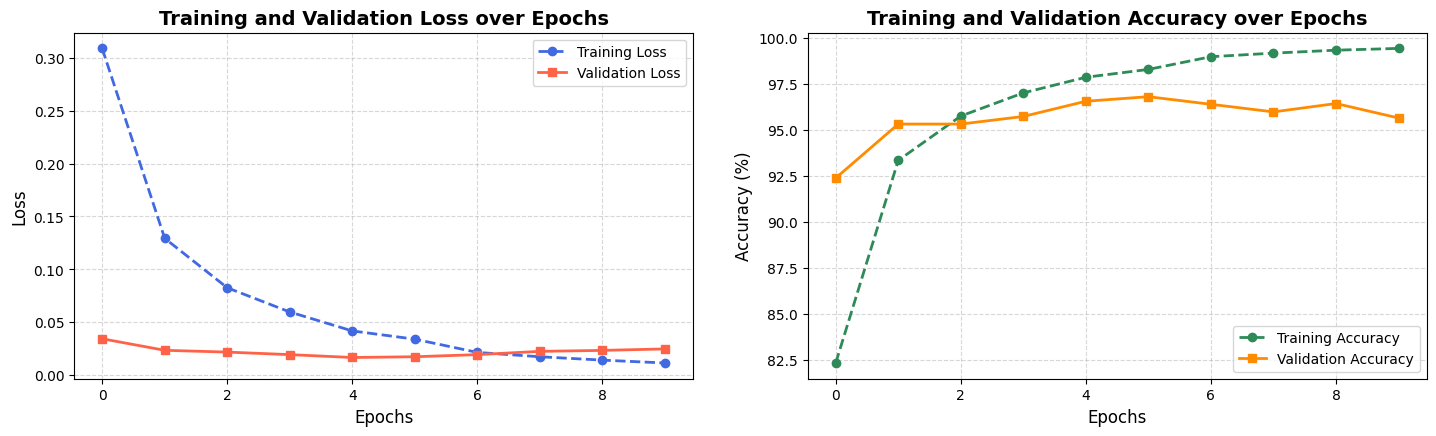

In [19]:
#visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)  # Create side-by-side plots with higher resolution

# Training and Validation Loss Plot
axs[0].plot(total_loss_train_plot, label='Training Loss', color='royalblue', linewidth=2, linestyle='--', marker='o')
axs[0].plot(total_loss_validation_plot, label='Validation Loss', color='tomato', linewidth=2, linestyle='-', marker='s')
axs[0].set_title('Training and Validation Loss over Epochs', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend(loc='upper right', fontsize=10)

# Training and Validation Accuracy Plot
axs[1].plot(total_acc_train_plot, label='Training Accuracy', color='seagreen', linewidth=2, linestyle='--', marker='o')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy', color='darkorange', linewidth=2, linestyle='-', marker='s')
axs[1].set_title('Training and Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Accuracy (%)', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend(loc='lower right', fontsize=10)

plt.tight_layout(pad=3.0)  # Adjust spacing between plots
plt.show()

In [20]:
#inference, by uploading an image


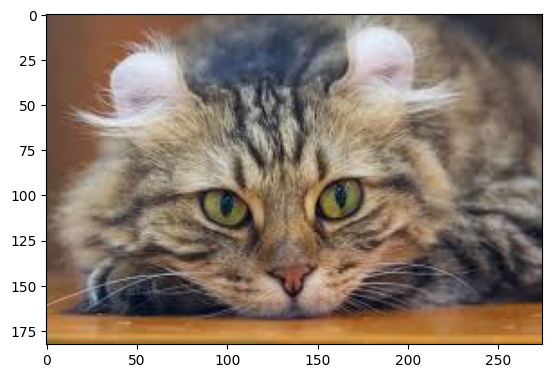


Prediction: 



array(['cat'], dtype=object)

In [26]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(img_path):
  image = Image.open(img_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/kat.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/kat.jpg")

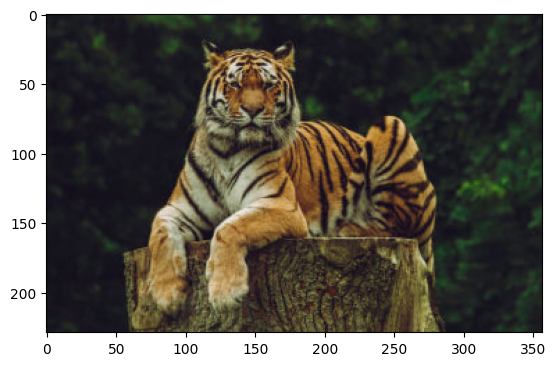


Prediction: 



array(['wild'], dtype=object)

In [27]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(img_path):
  image = Image.open(img_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/tiger.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/tiger.jpg")

In [ ]:
# learning from Learn PyTorch in 5 Projects – Tutorial Youtube Video by freeCodeCamp.org